In [17]:
%load_ext autoreload
%autoreload 2

In [1]:
from notebook_utils.data_generation import *
from pycss.subset_selection import *
from pycss.utils import *
from pycss.CSS import *
from pycss.model_selection import *
import numpy as np
import pandas as pd
import scipy 
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import chi2
from choldate import cholupdate
import multiprocessing
from multiprocessing import Pool
from functools import partial
from tqdm.notebook import tqdm as tqdm_notebook
from rpy2.robjects.conversion import localconverter
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
import rpy2.robjects.numpy2ri as n2r
import itertools
import time
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches

efa = rpackages.importr('EFAutilities')
n2r.activate()

Compare asymptotic to finite sample distribution

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

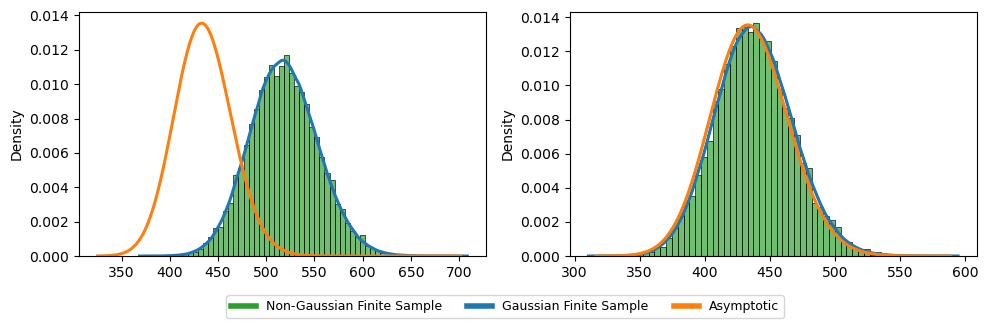

In [16]:
def compute_test_stat(Sigma, S, n):
    p = Sigma.shape[0]
    Sigma_R = regress_off(Sigma, S)
    S_comp = complement(p, S)
    test_stat = n*(np.sum(np.log(np.diag(Sigma_R)[S_comp])) - np.linalg.slogdet(Sigma_R[S_comp, :][:, S_comp])[1])
    return test_stat

p = 50
k = 20
B = int(1e4)
df = int((p-k) * (p-k-1)/2)
linewidth=2.2
alpha=0.68
bins=50
params = np.arange(1, 11)

W = np.random.seed(0)
W = np.random.normal(0, 1, (p-k, k))
W = W/np.linalg.norm(W, axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(10 , 3 ))

n = 200
real_dist = np.array(np.zeros(B))
for i in tqdm_notebook(np.arange(B)):
    X_S = np.random.normal(0, 1, (n, k)) 
    eps1 = np.random.chisquare(params, size=(n, len(params))) - params
    eps2 = np.random.uniform(-1*params, params, size=(n, len(params)))
    eps3 = np.random.poisson(params, size=(n, len(params))) - params 
    eps = np.hstack([eps1, eps2, eps3])
    X_S_comp = X_S @ W.T + eps
    X = np.hstack([X_S, X_S_comp])
    _, Sigma_hat = get_moments(X)
    real_dist[i] = compute_test_stat(Sigma_hat, np.arange(k), n)
sns.histplot(real_dist, color='tab:green', ax=axes[0], stat='density', bins=bins, alpha=alpha)
finite_sample_dist = sample_null_dist(n, p, k, B=int(1e6))
sns.kdeplot(finite_sample_dist, ax=axes[0], color='tab:blue', linewidth=linewidth)
x = np.arange(min(finite_sample_dist) - 50, max(finite_sample_dist), 0.001)
sns.lineplot(x=x, y=chi2.pdf(x, df=df), ax=axes[0], color='tab:orange', linewidth=linewidth)


n = 5000
real_dist = np.array(np.zeros(B))
for i in tqdm_notebook(np.arange(B)):
    X_S = np.random.normal(0, 1, (n, k)) 
    eps1 = np.random.chisquare(params, size=(n, len(params))) - params
    eps2 = np.random.uniform(-1*params, params, size=(n, len(params)))
    eps3 = np.random.poisson(params, size=(n, len(params))) - params 
    eps = np.hstack([eps1, eps2, eps3])
    X_S_comp = X_S @ W.T + eps
    X = np.hstack([X_S, X_S_comp])
    _, Sigma_hat = get_moments(X)
    real_dist[i] = compute_test_stat(Sigma_hat, np.arange(k), n)
sns.histplot(real_dist, color='tab:green', ax=axes[1], stat='density', bins=bins, alpha=alpha)
finite_sample_dist = sample_null_dist(n, p, k, B=int(1e6))
sns.kdeplot(finite_sample_dist, ax=axes[1], color='tab:blue', linewidth=linewidth)
x = np.arange(min(finite_sample_dist), max(finite_sample_dist), 0.001)
sns.lineplot(x=x, y=chi2.pdf(x, df=df), ax=axes[1], color='tab:orange')

finite_sample_dist = sample_null_dist(n, p, k, B=int(1e6))
sns.kdeplot(finite_sample_dist, ax=axes[1], color='tab:blue')

x = np.arange(min(finite_sample_dist), max(finite_sample_dist), 0.001)
sns.lineplot(x=x, y=chi2.pdf(x, df=df), ax=axes[1], color='tab:orange', linewidth=linewidth)


finite_sample_handle, = plt.plot([], [], color='tab:blue', label='Gaussian Finite Sample', linewidth=4)
asymptotic_handle, = plt.plot([], [], color='tab:orange', label='Asymptotic', linewidth=4)
real_handle, = plt.plot([], [], color='tab:green', label='Non-Gaussian Finite Sample', linewidth=4)


leg = fig.legend(handles=[real_handle, finite_sample_handle, asymptotic_handle], prop={'size': 9}, bbox_to_anchor=(0.795, 0.02), ncol=3)  
plt.tight_layout()

plt.savefig("../figures/dist_comparison.pdf", bbox_inches='tight')

### Simulation

In [2]:
p = 50
k = 20
rho = 0.5
C_chol = scipy.linalg.block_diag(get_equicorrelated_chol(4, rho, diag=1), 
                        get_equicorrelated_chol(4, rho, diag=1),
                        get_equicorrelated_chol(4, rho, diag=1),
                        get_equicorrelated_chol(4, rho, diag=1),
                        get_equicorrelated_chol(4, rho, diag=1))
C = C_chol @ C_chol.T

#C, C_chol = np.eye(k), np.eye(k)

W = get_block_W(p, k, num_blocks=4, block_size=8, overlap=4)

np.random.seed(0)
W *= np.random.choice(np.array([-1, 1]), W.shape)
#W = np.random.normal(0, 1, (p-k, k))
#W = W/np.linalg.norm(W, axis=1)[:, np.newaxis]



D = np.concatenate([np.arange(1, 7) for i in range(5)] )
#D = np.ones(p-k)


B = 1000
method = 'swap'
num_inits = 10 
#noise_levels = [0.022, 0.81, 2.71, 9.2, 350]
noise_levels = [0.254, 0.812, 2.71, 9.2, 30.0]
#noise_levels = [0.81, 2.71, 9.2]
#noise_levels = [(1-c)/c for c in [0.25, 0.5, 0.75]]
ns = [100, 200, 300, 400, 500]
alpha = 0.05

gaussian_unique_factors = False

if not gaussian_unique_factors:
    np.random.seed(0)
    unique_factor_perm = np.random.choice(np.arange(p-k), size=p-k, replace=False)

def make_Sigma(C, W, D):
    k = C.shape[0]
    p = k + W.shape[0]
    Sigma = np.zeros((p, p))
    Sigma[:k, :k] = C.copy()
    Sigma[k:, :k] = W @ C
    Sigma[:k, k:] = (W @ C).T
    Sigma[k:, k:] = W @ C @ W.T + np.diag(D)
    return Sigma

signal_to_Sigma = {np.mean(np.diag(W @ C @ W.T)/(np.diag(W @ C @ W.T) + noise_level*D)): 
                   make_Sigma(C, W, noise_level*D)
                   for noise_level in noise_levels }


In [52]:
np.where((20 <= unique_factor_perm) & ( unique_factor_perm <= 29) )[0] + 1

array([ 2,  5,  6,  7, 10, 15, 16, 18, 25, 28])

In [46]:
np.random.seed(0)
unique_factor_perm = np.random.choice(np.arange(p-k), size=p-k, replace=False)
np.argsort(unique_factor_perm)

array([26, 16,  0, 25, 19, 10, 18, 23, 12, 22,  3,  7, 29,  2, 13, 28, 11,
        8, 20, 21, 15, 27,  9, 14,  5, 24,  4,  6,  1, 17])

In [4]:
quantile_dict = {}

for n in ns:
    for i in range(p+1):
        quantile_dict[(1-alpha, n, p, i)] = Q(1 - alpha, n, p, i)

In [5]:
def cannonical_correlation(Sigma, S1, S2):
    return np.trace(Sigma[S1, :][:, S2] @ np.linalg.inv(Sigma[S2, :][:, S2]) @ Sigma[S2, :][:, S1] @ np.linalg.inv(Sigma[S1, :][:, S1]))  

def get_df_from_frames(results_frames, k, signal_to_Sigma):
    pop_S = np.arange(k)
    results_df = pd.DataFrame(results_frames)
    results_df['Size of Selected Subset'] = [len(S) for S in results_df['Selected']]
    results_df['# Correct Variables Selected'] = [len(set(S).intersection(set(pop_S))) for S in results_df['Selected']]
    results_df['Sum of Sq. Cannonical Correlations'] = [cannonical_correlation(signal_to_Sigma[results_df['Avg. $R^2$'][i]], pop_S, results_df['Selected'][i]) for i in range(len(results_df))]
    return results_df

In [6]:
results_frames = {'Avg. $R^2$': [], 'Sample Size' : [], 'Selected': []}

for noise_level, n in tqdm_notebook(list(itertools.product(*[noise_levels, ns]))):
    results_frames['Avg. $R^2$'] += list(np.mean(np.diag(W @ C @ W.T)/(np.diag(W @ C @ W.T) + noise_level*D)) * np.ones(B))
    results_frames['Sample Size'] += list(n * np.ones(B))
    
    if gaussian_unique_factors: 
        Sigma_hats = generate_gaussian_PCSS_sample_cov(n, C_chol, W, D=noise_level*D, B=B)
    else:
        X_S = np.random.normal(0, 1, (B, n, k)) @ C_chol.T[np.newaxis, :, :]
        eps1 = (np.random.exponential(1, size=(B, n , int((p-k)/3))) - 1) 
        eps2 = np.random.choice([-1, 1], size=(B, n, int((p-k)/3)))
        eps3 = np.random.standard_t(3, size=(B, n , int((p-k)/3))) / np.sqrt(3)
        eps = np.dstack([eps1, eps2, eps3])[:, :, unique_factor_perm] * np.sqrt(noise_level*D)[np.newaxis, np.newaxis, : ]
        X_S_comp = X_S @ np.transpose(W[np.newaxis, : , :], axes=(0, 2, 1)) + eps
        X = np.dstack([X_S, X_S_comp])
        X_c = X - np.mean(X, axis=1)[:, np.newaxis, :]  
        Sigma_hats = 1/n * np.transpose(X_c, (0, 2, 1) ) @ X_c
    
    mp_func = partial(select_subset_from_cov, n=n, alpha=alpha, num_inits=num_inits, quantile_dict=quantile_dict)
    with Pool(multiprocessing.cpu_count()) as pool:
        results_frames['Selected'] +=  list(tqdm_notebook(pool.imap_unordered(mp_func, list(Sigma_hats))))
    
results_df = get_df_from_frames(results_frames, k, signal_to_Sigma)


  0%|          | 0/25 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Write

In [7]:
#if gaussian_unique_factors:
#    results_df.to_csv('results/gaussian_results.csv', index=False)
#if not gaussian_unique_factors:
#    results_df.to_csv('results/non_gaussian_results', index=False)

Read

In [60]:
if gaussian_unique_factors:
    results_df = pd.read_csv('results/gaussian_results.csv')
#if not gaussian_unique_factors:
#    results_df = pd.read_csv('results/non_gaussian_results')

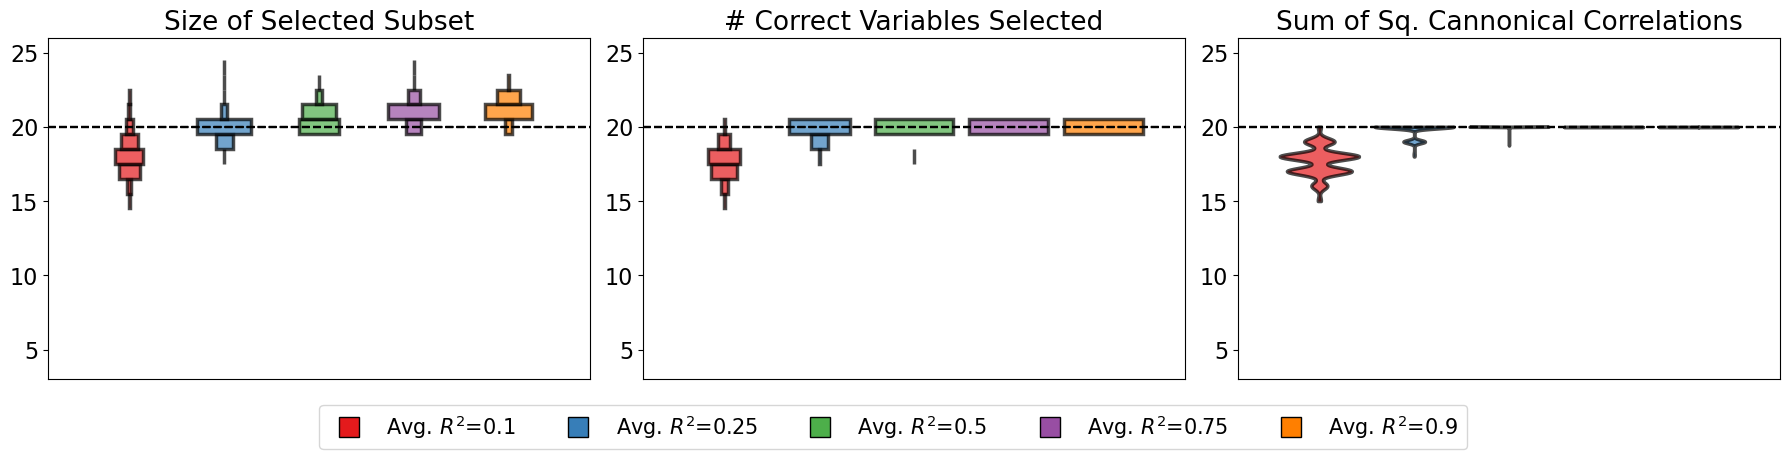

In [66]:
df = results_df.copy()
df['Avg. $R^2$'] = np.round(df['Avg. $R^2$'], 2)
plotting_ns = [500]
plotting_signal_sizes = [0.1, 0.25, 0.5, 0.75, 0.9]
fig, axes = plt.subplots(len(plotting_ns), 3, figsize=(18, 4*len(plotting_ns)))

responses = ['Size of Selected Subset', '# Correct Variables Selected', 'Sum of Sq. Cannonical Correlations']
y_min = np.min(df[responses]) - 1
y_max = np.max(df[responses]) + 1
width = 0.4
shift=1.2*width
x_positions = (np.arange(len(plotting_signal_sizes )) - int(len(plotting_signal_sizes )/2))*shift
x_min = min(x_positions) - 1.03*width
x_max = max(x_positions) + 1.03*width
color_palette = sns.color_palette('Set1', n_colors=len(plotting_signal_sizes ))
alpha = 0.7
linewidth=2.5
title_font_size=19
#edgewidth=1.5

bbox_num = 0.82345

#num_ns_to_bbox = {1: 0.81,
#                  5:0.81}

for i, n in enumerate(plotting_ns):
    for ell, signal_size in enumerate(plotting_signal_sizes ):
        color = color_palette[ell] 
        sub_df = df.loc[(df['Avg. $R^2$'] == signal_size) & (df['Sample Size'] == n)]
        for j, resp in enumerate(responses):

           
            if len(plotting_ns) == 1:
                ax = axes[j]
            else:
                ax = axes[i, j]
        
            ax.set_ylim([y_min, y_max])
            ax.set_xlim([x_min, x_max])
            ax.tick_params(axis='y', labelsize=16)
            vals = sub_df[resp].copy()
            
               
            if resp != 'Sum of Sq. Cannonical Correlations':
                unique_vals = set(vals)
                for unique_val in unique_vals:
                    prop = np.mean(vals == unique_val)
                    scaled_prop = prop*width
                    rect = plt.Rectangle(xy=(x_positions[ell] - scaled_prop/2, unique_val - 0.5),
                                         width=scaled_prop, 
                                         height=1, 
                                         color=color,
                                         linewidth=linewidth,
                                         alpha=alpha)
                    rect.set_edgecolor('black')

                    ax.add_patch(rect)
                    ax.set_title(resp, fontdict={'fontsize':title_font_size})
            
            if resp == 'Sum of Sq. Cannonical Correlations':
                violin = ax.violinplot(vals, 
                                       widths=[width], 
                                       positions=[x_positions[ell]],
                                       showmedians=False,
                                       showextrema=False)
                violin['bodies'][0].set_facecolor(color)
                violin['bodies'][0].set_alpha(alpha)
                violin['bodies'][0].set_edgecolor('black')
                violin['bodies'][0].set_linewidth(linewidth)
                ax.set_title(resp, fontdict={'fontsize':title_font_size})

# Show the plot
            
            #ax.boxplot(sub_df.loc[sub_df["Avg. $R^2$"] == signal_size][resp], 
            #           positions=[x_positions[ell]],
            #           patch_artist=True, 
            #           widths=width,
            #           boxprops=dict(facecolor=color,
            #                         alpha=alpha,
            #                         linewidth=linewidth),
            #           whiskerprops=dict(linewidth=linewidth),
            #           medianprops=dict(color='black'),
            #           flierprops={'marker': 'D', 
            #                       'markerfacecolor': color, 
            #                       'markersize': 6,
            #                       'markeredgewidth': edgewidth,
            #                       'alpha': alpha})
            
            ax.axhline(y=20, color='black', linestyle='--')  # Add a horizontal line at y=20
            ax.set_xticks([])
    
handles = []
labels = []
for ell, s in enumerate(plotting_signal_sizes):
    # Create your plot elements and store the handles and labels
    handle = Line2D([], [], marker='s', linestyle='None', markersize=15,
                    markeredgecolor='black', color=color_palette[ell])
    handles.append(handle)
    labels.append('Avg. $R^2$=' + str(s))

handler_map = {mpatches.Patch: HandlerPatch(patch_func=lambda orig_handle, _: orig_handle)}
fig.legend(handles=handles, labels=labels, handler_map=handler_map, prop={'size': 15}, bbox_to_anchor=(bbox_num, 0.00), ncols=len(plotting_signal_sizes))
plt.tight_layout()


if len(plotting_ns) == 1 and gaussian_unique_factors:
    plt.savefig("../figures/model_selec_results_n=" +  str(int(plotting_ns[0])) + "_gaussian.pdf", bbox_inches='tight')
if len(plotting_ns) == 1 and not gaussian_unique_factors:
    plt.savefig("../figures/model_selec_results_n=" + str(int(plotting_ns[0])) + "_non_gaussian.pdf", bbox_inches='tight')
if len(plotting_ns) > 1 and gaussian_unique_factors:
    plt.savefig("../figures/model_selec_results_gaussian.pdf", bbox_inches='tight')
if len(plotting_ns) > 1 and not gaussian_unique_factors:
    plt.savefig("../figures/model_selec_results_non_gaussian.pdf", bbox_inches='tight')

In [8]:
# print out Type I error rate
for i, n in enumerate(plotting_ns):
    for j, signal_size in enumerate(plotting_signal_sizes):
        print(n, signal_size, np.mean(df.loc[(df['Avg. $R^2$'] == signal_size) & (df['Sample Size'] == n)]['Size of Selected Subset'] > 20 ))

200.0 0.1 0.01
200.0 0.25 0.07
200.0 0.5 0.25
200.0 0.75 0.81
200.0 0.9 0.91


In [ ]:
if len(ns) == 1:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Adjust the figsize as per your preference

    # Load and display the first plot
    first_plot = plt.imread("../figures/model_selec_results_n= + " str(ns[0]) + "._gaussian.pdf")
    axs[0].imshow(first_plot)
    axs[0].axis('off')

    # Load and display the second plot
    second_plot = plt.savefig("../figures/model_selec_results_n= + " str(ns[0]) + "_non_gaussian.pdf")
    axs[1].imshow(second_plot)
    axs[1].axis('off')
    
    plt.show()
    #plt.savefig("../figures/model_selec_results.pdf")

### Real Data Analysis

In [67]:
X = pd.read_csv("../data/BFI228.csv").values[:, 1:].astype(float)
n, p = X.shape

(array([1., 2., 1., 2., 3., 4., 2., 6., 1., 2.]),
 array([0.36515843, 0.39310293, 0.42104744, 0.44899195, 0.47693646,
        0.50488096, 0.53282547, 0.56076998, 0.58871449, 0.61665899,
        0.6446035 ]),
 <BarContainer object of 10 artists>)

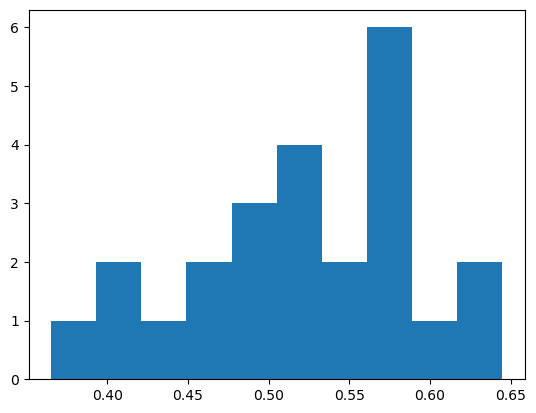

In [68]:
css = CSS()
css.select_subset_from_data(X, k=20, method='swap', num_inits=10)
plt.hist(np.diag(css.Sigma_R)[complement(p, css.S)])

In [69]:

alpha = 0.05
quantile_dict = {(1 - alpha, n, p, i,):  Q(1 -alpha, n, p, i,) for i in range(p + 1) }
start = time.time()
S = select_subset(X, 
                  alpha=alpha,  
                  quantile_dict=quantile_dict, 
                  num_inits=1)
end = time.time()
print(end - start)
print(len(S))
print(S)
print(len(np.where(np.logical_and(S>=0, S<=7))[0]))
print(len(np.where(np.logical_and(S>=8, S<=16))[0]))
print(len(np.where(np.logical_and(S>=17, S<=25))[0]))
print(len(np.where(np.logical_and(S>=26, S<=33))[0]))
print(len(np.where(np.logical_and(S>=34, S<=43))[0]))

0.05902886390686035
19
[29  7 12 20  2 15 22 24 31 37 13 38  0 25 14  6 27 43 19]
4
4
5
3
3


In [70]:
with localconverter(robjects.default_converter + n2r.converter) as cv:
    factor_result = efa.efa(x=X[:, np.sort(S)], factors=5)

In [71]:
np.round(factor_result['rotated'], 2)

array([[ 0.11,  0.77,  0.1 , -0.06, -0.03],
       [-0.14,  0.54,  0.1 ,  0.25,  0.13],
       [ 0.23, -0.54,  0.07,  0.19, -0.05],
       [-0.02,  0.81, -0.01,  0.1 ,  0.02],
       [ 0.03,  0.17, -0.06,  0.47,  0.15],
       [ 0.14, -0.16,  0.16, -0.66,  0.02],
       [ 0.12, -0.08,  0.21,  0.67,  0.07],
       [ 0.35,  0.09, -0.06, -0.52, -0.07],
       [ 0.1 ,  0.11, -0.01,  0.23,  0.48],
       [ 0.09,  0.11,  0.14, -0.01, -0.6 ],
       [-0.03, -0.09,  0.24, -0.03,  0.55],
       [ 0.06,  0.11, -0.02,  0.05,  0.66],
       [ 0.5 , -0.03,  0.01,  0.12, -0.36],
       [-0.57,  0.02,  0.03,  0.05,  0.1 ],
       [ 0.63, -0.07, -0.15,  0.07, -0.08],
       [ 0.79,  0.03, -0.02, -0.13,  0.09],
       [ 0.01,  0.11,  0.68,  0.01, -0.06],
       [-0.1 ,  0.04,  0.76, -0.01,  0.03],
       [ 0.05, -0.14,  0.5 ,  0.07,  0.  ]])

In [72]:
with localconverter(robjects.default_converter + n2r.converter) as cv:
    factor_result = efa.efa(x=X, factors=5)
    
np.round(factor_result['rotated'], 2)

array([[ 0.15,  0.08,  0.75, -0.  , -0.04],
       [ 0.19,  0.02, -0.53,  0.  ,  0.06],
       [-0.15,  0.08,  0.52,  0.3 ,  0.1 ],
       [-0.02,  0.22,  0.6 ,  0.35, -0.03],
       [ 0.03,  0.  , -0.8 ,  0.08, -0.02],
       [-0.13,  0.25,  0.52, -0.16,  0.11],
       [ 0.19,  0.08, -0.63,  0.17, -0.08],
       [ 0.  , -0.05,  0.75,  0.14,  0.04],
       [ 0.25, -0.  , -0.03, -0.39, -0.04],
       [ 0.02,  0.08, -0.01,  0.44,  0.12],
       [ 0.23,  0.05,  0.14, -0.57, -0.1 ],
       [-0.  ,  0.04,  0.03,  0.56, -0.02],
       [ 0.03, -0.09,  0.17,  0.55,  0.07],
       [ 0.12,  0.15, -0.12, -0.68,  0.02],
       [ 0.12,  0.23, -0.12,  0.67,  0.07],
       [ 0.29, -0.04,  0.11, -0.53, -0.1 ],
       [ 0.11, -0.01,  0.2 ,  0.55,  0.21],
       [-0.02,  0.08, -0.  ,  0.01,  0.72],
       [ 0.23,  0.21,  0.05,  0.  , -0.46],
       [ 0.11,  0.04,  0.08,  0.18,  0.54],
       [ 0.  ,  0.18,  0.07,  0.02, -0.68],
       [ 0.1 ,  0.04, -0.05, -0.09, -0.52],
       [-0.02,  0.22, -0.08, -0.